### Zadanie rekrutacyjne - Product Analyst Otodom 
### Agnieszka Spychała

In [1]:
import sqlite3
import pandas as pd
import datetime as dt
from datetime import date
import calendar
import matplotlib.pyplot as plt
import numpy as np
import operator as op
import seaborn as sns
import re
from collections import Counter
from functools import reduce
import jenkspy

##### Utworzenie bazy danych w SQLite

In [2]:
conn = sqlite3.connect('sql.db')

In [3]:
cursor = conn.cursor()

##### Wczytanie plików wejściowych csv


In [4]:
ads = pd.read_csv('data_ads.csv', sep=';', names = ['date','user_id','ad_id','category_id','params'])
ads['date'] = pd.to_datetime(ads['date'])
ads['day_of_week'] = ads['date'].dt.day_name()
replies = pd.read_csv('data_replies.csv', sep=';', names=["date", "user_id", "ad_id", "mails", "phones"])
replies = replies.fillna(0)
replies['date'] = pd.to_datetime(replies['date'])
replies['phones'] = replies['phones'].astype(int)
cat = pd.read_csv('data_categories.csv', sep=';', names=["category_id", "category_name"])
seg = pd.read_csv('data_segments.csv', sep=';', names=["user_id", "segment"])

In [5]:
ads[0:3]

,date,user_id,ad_id,category_id,params,day_of_week
0,2019-04-02,2467510,58563324,102,price<=>price<br>price<=>3100<br>price[currenc...,Tuesday
1,2019-04-02,530533,58563976,401,price<=>price<br>price<=>360000<br>price[curre...,Tuesday
2,2019-04-03,131944,58571784,201,price<=>price<br>price<=>288000<br>price[curre...,Wednesday


##### Import wczytanych plików csv do bazy danych

In [6]:
ads.to_sql('ads', conn, if_exists='replace', index=False)
replies.to_sql('replies', conn, if_exists='replace', index=False)
cat.to_sql('cat', conn, if_exists='replace', index=False)
seg.to_sql('seg', conn, if_exists='replace', index=False)

##### Wyliczenie wskaźnika liquidity

In [7]:
query = """
SELECT user_id, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.user_id as user_id, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.user_id
)
GROUP BY user_id
"""
cursor.execute(query)
liquidity = dict(cursor.fetchall())

In [8]:
pd.Series(list(liquidity.values())).describe()

count    334.000000
mean       0.543458
std        0.313424
min        0.000000
25%        0.333333
50%        0.500000
75%        0.800000
max        1.000000
dtype: float64

##### Wyliczenie wskaźnika liquidity dla poszczególnych kategorii

In [9]:
query = """
SELECT category_id, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.category_id as category_id, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.category_id
)
GROUP BY category_id
"""
cursor.execute(query)
cat_liq = dict(cursor.fetchall())

In [10]:
cat

,category_id,category_name
0,1,na sprzedaż
1,2,na wynajem
2,11,Inwestycje
3,21,Projekty
4,101,Mieszkania na sprzedaż
5,102,Mieszkania na wynajem
6,201,Domy na sprzedaż
7,202,Domy na wynajem
8,302,Pokoje na wynajem
9,401,Działki na sprzedaż


In [11]:
cat_liq
{k: v for k, v in sorted(cat_liq.items(), key=lambda item: item[1])}

{702: 0.0,
 601: 0.2222222222222222,
 502: 0.2254335260115607,
 602: 0.24242424242424243,
 501: 0.2727272727272727,
 401: 0.2753623188405797,
 402: 0.3333333333333333,
 202: 0.37254901960784315,
 101: 0.38179952104002735,
 201: 0.46444780635400906,
 701: 0.5,
 102: 0.5439838220424671,
 302: 1.0}

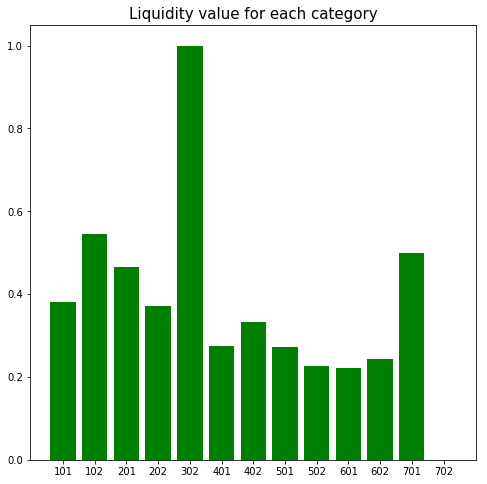

In [12]:
plt.figure(figsize=(8,8))
plt.bar(range(len(cat_liq)), list(cat_liq.values()), align='center', color = 'g')
plt.xticks(range(len(cat_liq)), list(cat_liq.keys()))
plt.title("Liquidity value for each category", fontsize=15)
plt.savefig('categories.png')
plt.show()

In [13]:
print(ads.groupby(['category_id'])['category_id'].count(), cat)

category_id
101    2923
102     989
201     661
202      51
302       2
401     414
402       3
501      77
502     346
601       9
602      66
701       4
702       1
Name: category_id, dtype: int64     category_id                category_name
0             1                  na sprzedaż
1             2                   na wynajem
2            11                   Inwestycje
3            21                     Projekty
4           101       Mieszkania na sprzedaż
5           102        Mieszkania na wynajem
6           201             Domy na sprzedaż
7           202              Domy na wynajem
8           302            Pokoje na wynajem
9           401          Działki na sprzedaż
10          402           Działki na wynajem
11          501  Lokale użytkowy na sprzedaż
12          502   Lokale użytkowy na wynajem
13          601    Hale/Magazyny na sprzedaż
14          602     Hale/Magazyne na wynajem
15          701           Garaże na sprzedaż
16          702            Garaże n

Widoczna jest zależność pomiędzy wartością wskaźnika liquidity, a kategorią ogłoszenia. Trudno jednoznacznie określić, które kategorie ogłoszeń są chętniej przeglądane przez klientów, z uwagi na niewielką liczbę ogłoszeń, w niektórych kategoriach. Np. dla kategorii "Pokoje na wynajem" liquidity wg danych wynosi 100%, jednak liczba ogłoszeń to tylko 2, a dla kategorii "Garaże na wynajem" liquidity jest równe 0%, jednak zamieszczono tylko jedno ogłoszenie. Jednak biorąc pod uwagę tylko kategorie, w których zamieszczono co najmniej 300 ogłoszeń wg dostępnych danych największą wartość liquidity (54%) osiągnęła kategoria "Mieszkania na wynajem". Natomiast wartość analizowanego współczynnika była najmniejsza dla kategorii "Lokale użytkowe na wynajem" i wynosiła tylko 22%.

##### Rozkład wskaźnika liquidity dla poszczególnych segmentów

In [14]:
seg_mapping = dict(list(zip(seg['user_id'], seg['segment'])))

In [15]:
seg_liq = {'Beginners': [], 'Sharks': [], 'Hipot': []}
for k,v in liquidity.items():
    seg_liq[seg_mapping[k]].append(v)

In [16]:
labels, data = seg_liq.keys(), seg_liq.values()
labels

dict_keys(['Beginners', 'Sharks', 'Hipot'])

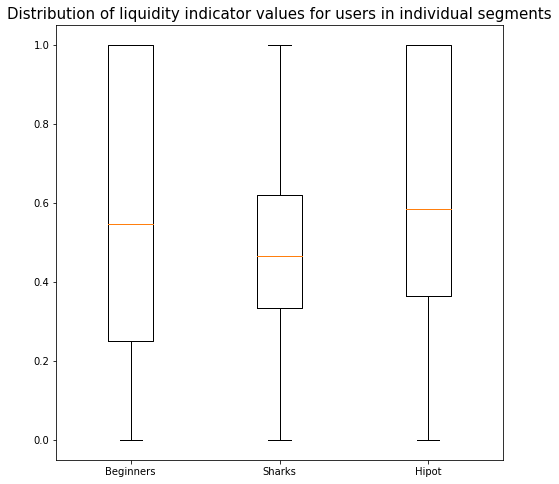

In [17]:
#tworzenie wykresu pudełkowego
plt.figure(figsize=(8,8))
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("Distribution of liquidity indicator values for users in individual segments" , fontsize=15)
plt.savefig('segments.png')
plt.show()

In [18]:
df_beg = pd.DataFrame.from_dict(seg_liq['Beginners'])
df_sha = pd.DataFrame.from_dict(seg_liq['Sharks'])
df_hip = pd.DataFrame.from_dict(seg_liq['Hipot'])
df_beg.describe() #podstawowe miary statystyczne dla liquidity segmentu Beginners

,0
count,134.000000
mean,0.553674
std,0.355836
min,0.000000
25%,0.250000
50%,0.545455
75%,1.000000
max,1.000000


In [19]:
df_sha.describe() #podstawowe miary statystyczne dla liquidity segmentu Sharks

,0
count,111.000000
mean,0.487204
std,0.240600
min,0.000000
25%,0.333333
50%,0.466667
75%,0.620192
max,1.000000


In [20]:
df_hip.describe() #podstawowe miary statystyczne dla liquidity segmentu Hipot

,0
count,89.000000
mean,0.598238
std,0.317516
min,0.000000
25%,0.363636
50%,0.583333
75%,1.000000
max,1.000000


In [21]:
seg_users = {'Beginners': [], 'Sharks': [], 'Hipot': []}
for k,v in seg_mapping.items():
    seg_users[seg_mapping[k]].append(k)

#### Wyliczenie liczby ogłoszeń zamieszczonych w poszczególnych segmentach

In [22]:
query = """
SELECT  seg.segment, count(*) as ad_count
FROM ads
INNER JOIN seg ON ads.user_id=seg.user_id
GROUP BY seg.segment 
"""
cursor.execute(query)
seg_ad_count = dict(cursor.fetchall())

In [23]:
seg_ad_count #liczba ogłoszeń w poszczególnych segmentach

{'Beginners': 858, 'Hipot': 535, 'Sharks': 4153}

#### Wyliczenie liczby użytkowników w poszczególnych segmetach

In [24]:
query = """
SELECT  segment, count(*) 
FROM seg
GROUP BY segment 
"""
cursor.execute(query)
seg_count = dict(cursor.fetchall())

In [25]:
seg_count #liczba użytkowników w poszczególnych segmentach

{'Beginners': 178, 'Hipot': 111, 'Sharks': 116}

#### Średnia liczba ogłoszeń na jednego użytkownika w danych segmentach

In [26]:
seg_mean = dict((k, float(seg_ad_count[k]) / seg_count[k]) for k in seg_ad_count)
seg_mean

{'Beginners': 4.820224719101123,
 'Hipot': 4.81981981981982,
 'Sharks': 35.80172413793103}

W zbiorze danych istnieją 3 segmenty użytkowników: Beginners, Sharks oraz Hipot. Najwięcej użytkowników jest w segmencie Beginners - 178, w segmencie Sharks jest 116 użytkowników, a w segmencie Hipot 111, z czego w dostępnej bazie danych ogłoszenia wystawiane były przez odpowiednio 134, 111 i 89 użytkowników w poszczególnych segmentach. Rozkłady wartości wskaźnika liquidity dla użytkowników z segmentów Beginners oraz Hipot są bardzo zbliżone do siebie. Średnie dla tych segmentów wynoszą powyżej 50%, natomiast różnice między trzecim i pierwszym kwartylem obejmują szeroki zakres rozkładów - dla Beginners są to wartości pomiędzy 25% a 100 %, a dla Hipot pomiędzy 36% a 100%. Natomiast segment użytkowników Shark znacząco różni się od pozostałych dwóch. Średnia w tym przypadku jest niższa od 50%, a wartości pomiędzy trzecim i pierwszym kwartylem obejmują dużo mniejszy przedział niż pozostałych dwóch segmentach - od 33% do 62%. Niewątpliwie wpływ na gorsze statystyki dla segmentu Sharks ma fakt, iż użytkownicy z tej grupy wystawiali znacznie więcej ogłoszeń niż w pozostałych 2 grupach i było to średnio prawie 36 ogłoszeń na użytkownika. W segmentach Beginner i Hipot średnia liczba ogłoszeń umieszczanych przez użytkowników wynosiła tylko około 5. Segment użytkownika może być kolejnym istotnym czynnikiem determinującym wartość wskaźnika liquidity. Z dostępnych danych wynika, iż użytkownicy z segmentu Shark umieszczają średnio najwięcej ogłoszeń, jednak statystycznie osiągają one najgorsze wyniki, jeśli chodzi o liczbę wyświetleń w pierwszym tygodniu. Segment Sharks jest to najbardziej aktywna grupa użytkowników. Największe szanse na wysoką wartość wskaźnika mają użytkownicy z segmentu Hipot. Prawdopodobnie ogłoszenia dodawane przez sprzedawców z grupy Hipot są lepiej odbierane przez klientów, niż te umieszczane przez grupę Beginners, dzięki większemu doświadczeniu w sprzedaży tej grupy użytkowników.

##### Wpływ dni tygodni, w których umieszczane są ogłoszenia na wartość liquidity

In [27]:
replies['date'] = pd.to_datetime(replies['date'])
replies['day_of_week'] = replies['date'].dt.day_name()
replies['sum'] = replies['mails'] + replies['phones'].astype(int)

day_of_week
Friday       4989
Monday       8732
Saturday     3477
Sunday       5951
Thursday     5917
Tuesday      8136
Wednesday    6315
Name: sum, dtype: int64


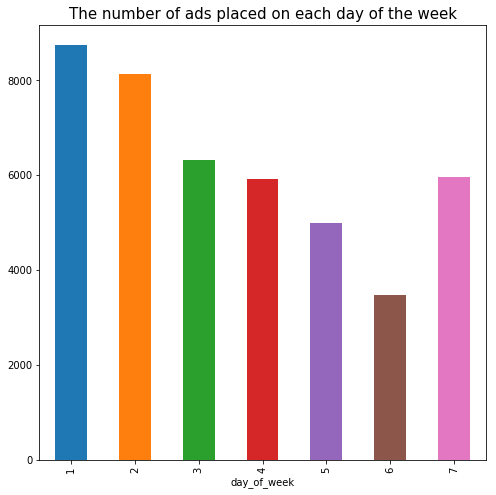

In [28]:
rep_days = replies.groupby(['day_of_week'], as_index = False).sum()
days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday': 4, 'Friday': 5,
                                            'Saturday': 6, 'Sunday': 7}
s = rep_days['day_of_week'].apply(lambda x: days[x])
s.sort_values()

fig = plt.figure(figsize=(8,8))
rep_days.set_index(s.sort_index()).sort_index()['sum'].plot.bar(x='day_of_week', y='sum')
plt.title("The number of ads placed on each day of the week",fontsize = 15)
plt.savefig('days.png')
print(replies.groupby(['day_of_week'])['sum'].sum())

Z powyższego wykresu wynika, iż najwięcej ogłoszeń zamieszczanych jest w poniedziałki. Liczba dodawanych ogłoszeń stopniowo spada w ciągu tygodnia - najmniej pojawiło się w soboty. W niedziele dodano więcej nowych ogłoszeń niż w soboty.

##### Wyliczenie wskaźnika liquidity w zależności od dnia, w którym umieszczono ogłoszenie

In [29]:
query = """
SELECT day_of_week, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.day_of_week as day_of_week, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.day_of_week
)
GROUP BY day_of_week
"""
cursor.execute(query)
ads_days_liq = dict(cursor.fetchall())

In [30]:
ads_dict = {'Days Liquidity' : ads_days_liq}
list_ = ads_days_liq.items()
mapping = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

new_list = list(zip(list_,[mapping[i[0]] for i in list_]))
new_list.sort(key=op.itemgetter(1))
ads_list = []
for i in range(len(new_list)):
    ads_list.append(new_list[i][0])

In [31]:
ads_dict = dict(ads_list)
ads_dict

{'Monday': 0.35190918472652216,
 'Tuesday': 0.37337413925019125,
 'Wednesday': 0.36023622047244097,
 'Thursday': 0.3827859569648924,
 'Friday': 0.3783209351753454,
 'Saturday': 0.7715355805243446,
 'Sunday': 0.7423312883435583}

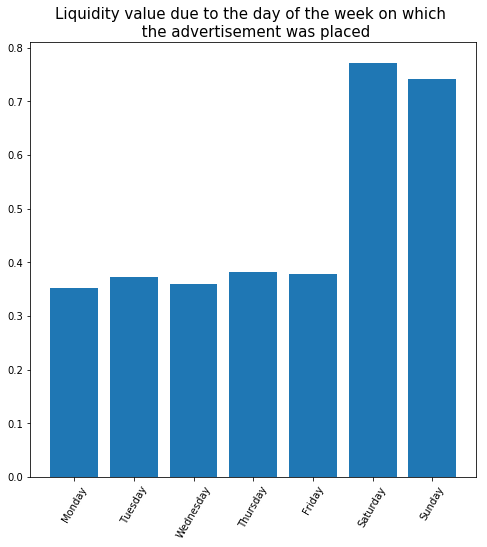

In [32]:
plt.figure(figsize=(8,8))
plt.bar(ads_dict.keys(), height = list(ads_dict.values()))
plt.xticks(rotation=60)
plt.title("Liquidity value due to the day of the week on which \n the advertisement was placed", fontsize = 15)
plt.savefig('liq_days.png')
plt.show()

Z powyżej tabeli wynika, iż wskaźnik liquidity jest znacząco większy dla ogłoszeń umieszczanych w soboty oraz niedziele od wartości wskaźnika dla ogłoszeń umieszczanych od poniedziałku do piątku. Można zatem stwierdzić, iż dzień tygodnia, w którym umieszczane są ogłoszenia ma istotny wpływ na wartość wskaźnika liquidity. Najwięcej ogłoszeń dodawanych jest natomiast na początku tygodnia. 

#### Rozdzielenie kolumny params

In [33]:
par_columns = []
def split1(data):
    par = data['params']
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp)-1)):
            names = temp[j].split('<=>')
            par_columns.append(names[0])   

In [34]:
splited = split1(ads)

#### Ekstracja nazw kolumn parametrów zawartych w ciągu znaków params

In [35]:
par_columns
c = Counter(par_columns)
columns = reduce(lambda l, x: l+[x] if x not in l else l, par_columns, [])
columns

['price',
 'price[currency]',
 'rent',
 'rent[currency]',
 'deposit',
 'deposit[currency]',
 'm',
 'rooms_num',
 'building_type',
 'floor_no',
 'building_floors_num',
 'building_material',
 'windows_type',
 'heating',
 'build_year',
 'construction_status',
 'free_from',
 'rent_to_students',
 'equipment_types',
 'security_types',
 'media_types',
 'price_per_m',
 'type',
 'dimensions',
 'fence',
 'location',
 'access_types',
 'terrain_area',
 'market',
 'floors_num',
 'garret_type',
 'roof_type',
 'roofing',
 'recreational',
 'fence_types',
 'heating_types',
 'vicinity_types',
 'extras_types',
 'building_ownership',
 'use_types',
 'height',
 'structure',
 'parking',
 'flooring',
 'office_space',
 'social_facilities',
 'ramp',
 'localization',
 'lighting',
 'roomsize',
 'non_smokers_only']

#### Utworzenie nowych kolumn na podstawie danych zawartych w zmiennej params

In [36]:
for i in columns:
    ads[i] = 0

#### Wypełnienie nowo utworzonych kolumn danymi

In [37]:
def fill_column(data, string):
    par = data['params']
    new_column = data[string]
    n = 0
    m = 0
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp))):
            values = temp[j].split('<=>')
            if (values[0] == string):
                value1 = values[1]
                new_column[n] = value1
                n = n + 1
                m = m + 1
            

In [38]:
for i in columns:
    fill_column(ads, i)

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/agnieszka/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Dodanie do tabeli ads informacji czy dla danego ogłoszenie pojawiła się jakakolwiek odpowiedź w przeciągu pierwszych 7 dni od umieszczenia

In [39]:
query = """
SELECT replies.ad_id
FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id
WHERE ((replies.phones + replies.mails) > 0) AND (ads.date < date(ads.date, "+7 days")) 
"""
cursor.execute(query)
reply = cursor.fetchall()

In [40]:
len(reply) # liczba ogłoszeń z odpowiedzią

6963

In [41]:
reply_list = []
for i in range(0, len(reply)):
    reply_list.append(reply[i][0])
ads['reply'] = 0

In [43]:
for i in range(len(ads['ad_id'])):
    if ads['ad_id'][i] in reply_list:
        ads['reply'][i] = 1
    else: ads['reply'][i] = 0

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
ads['price'] = pd.to_numeric(ads['price'])
ads['price'] = (ads['price']).astype(int)
ads['m'] = pd.to_numeric(ads['m'])
ads.dtypes

date                   datetime64[ns]
user_id                         int64
ad_id                           int64
category_id                     int64
params                         object
day_of_week                    object
price                           int64
price[currency]                object
rent                           object
rent[currency]                 object
deposit                        object
deposit[currency]              object
m                             float64
rooms_num                      object
building_type                  object
floor_no                       object
building_floors_num            object
building_material              object
windows_type                   object
heating                        object
build_year                     object
construction_status            object
free_from                      object
rent_to_students               object
equipment_types                object
security_types                 object
media_types 

#### Ekstrakcja ogłoszeń dotyczących wyłącznie sprzedaży lub wynajmu mieszkań

Dalszą część analizy tzn. badanie wpływu dostępnych parametrów (pierwotnie znajdujących się w kolumnie params) na poziom liquidity, zdecydowałam się przeprowadzić na danych dotyczących wyłącznie sprzedaży mieszkań, ponieważ jest to najliczniej reprezentowana kategoria ogłoszeń w dostępnym zbiorze danych i jednocześnie prawdopodobnie najbardziej interesująca dla użytkowników w serwisie Otodom.

In [45]:
cat101 = ads[(ads.category_id == 101)] # mieszkania na sprzedaż (kategoria 101)

In [46]:
cat101 = cat101.sort_values(by='price')

In [47]:
cat101[0:3]

,date,user_id,ad_id,category_id,params,day_of_week,price,price[currency],rent,rent[currency],...,parking,flooring,office_space,social_facilities,ramp,localization,lighting,roomsize,non_smokers_only,reply
2573,2019-04-10,1641452,58689896,101,price<=>price<br>price<=>7000<br>price[currenc...,Wednesday,7000,PLN,490,PLN,...,0,0,0,0,0,0,0,0,0,1
5233,2019-04-02,1641452,58556620,101,price<=>price<br>price<=>12000<br>price[curren...,Tuesday,12000,PLN,220,0,...,0,0,0,0,0,0,0,0,0,1
1921,2019-04-10,1641452,58690044,101,price<=>price<br>price<=>24000<br>price[curren...,Wednesday,24000,PLN,399,PLN,...,0,0,0,0,0,0,0,0,0,1


#### Usunięcie wartości odstających - ograniczenia zakresu do najczęściej występujących wartości

In [48]:
# ograniczenie obserwacji do mieszkań na sprzedaż gdzie cena znajduje się w zakresie od 100k do 1m
lim101 = cat101[(cat101.price > 100000) & (cat101.price < 1000000 )] 
len(lim101)

2738

In [49]:
#utworzenie przedziałów dla których wyliczane będzie liquidity
breaks = np.arange(100000, 1000001, 50000).tolist()

In [50]:
lim101['intervals'] = pd.cut(lim101['price'],
                        bins=breaks,
                        labels =range(1,19,+1),
                        include_lowest=True)

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [51]:
lim101[0:3]

,date,user_id,ad_id,category_id,params,day_of_week,price,price[currency],rent,rent[currency],...,flooring,office_space,social_facilities,ramp,localization,lighting,roomsize,non_smokers_only,reply,intervals
1851,2019-04-16,3106352,58769984,101,price<=>price<br>price<=>105000<br>price[curre...,Tuesday,105000,PLN,250,PLN,...,0,0,0,0,0,0,0,0,1,1
3746,2019-04-16,530533,58776256,101,price<=>price<br>price<=>105000<br>price[curre...,Tuesday,105000,PLN,price,PLN,...,0,0,0,0,0,0,0,0,1,1
1983,2019-04-18,111337,58808836,101,price<=>price<br>price<=>105000<br>price[curre...,Thursday,105000,PLN,,PLN,...,0,0,0,0,0,0,0,0,1,1


In [52]:
#grupowanie dla przedziałów 
intervals101 = lim101.groupby('intervals')['reply'].apply(lambda x: x.sum()/x.count())
count101 = lim101.groupby('intervals')['reply'].count()
print(intervals101, count101)

intervals
1     0.852941
2     0.753623
3     0.709402
4     0.635514
5     0.599359
6     0.540000
7     0.418605
8     0.342007
9     0.193548
10    0.371795
11    0.240602
12    0.464286
13    0.391304
14    0.217391
15    0.205128
16    0.482759
17    0.421053
18    0.192308
Name: reply, dtype: float64 intervals
1      68
2     138
3     234
4     321
5     312
6     300
7     301
8     269
9     217
10    156
11    133
12     84
13     46
14     46
15     39
16     29
17     19
18     26
Name: reply, dtype: int64


In [53]:
#utworzenie dataframe z wyników group by
inter_liq = intervals101.to_frame()
inter_liq['count'] = list(count101)
inter_liq

,reply,count
intervals,,
1,0.852941,68
2,0.753623,138
3,0.709402,234
4,0.635514,321
5,0.599359,312
6,0.540000,300
7,0.418605,301
8,0.342007,269
9,0.193548,217


In [54]:
inter_liq['labels'] = ''
for i in range(len(inter_liq)):
    inter_liq['labels'][i] = str(breaks[i]) + ' - ' + str(breaks[i+1])

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
inter_liq

,reply,count,labels
intervals,,,
1,0.852941,68,100000 - 150000
2,0.753623,138,150000 - 200000
3,0.709402,234,200000 - 250000
4,0.635514,321,250000 - 300000
5,0.599359,312,300000 - 350000
6,0.540000,300,350000 - 400000
7,0.418605,301,400000 - 450000
8,0.342007,269,450000 - 500000
9,0.193548,217,500000 - 550000


#### Wpływ cen mieszkań na sprzedaż na liquidity

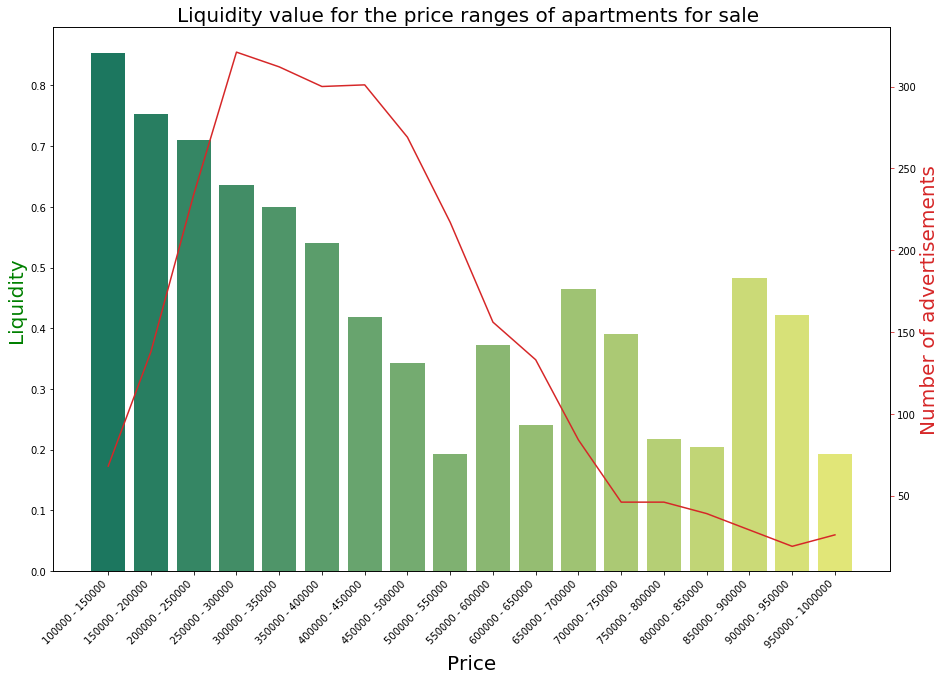

In [56]:
fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:green'
ax1.set_title('Liquidity value for the price ranges of apartments for sale ', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.grid(False)
ax2 = sns.barplot(x='labels', y='reply', data = inter_liq, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2 = sns.lineplot(x='labels', y='count', data = inter_liq, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.grid(False)
ax1.set_ylabel('Liquidity', fontsize=20, color='green')
ax1.set_xlabel('Price', fontsize=20)
ax2.set_ylabel('Number of advertisements', fontsize=20, color=color)
plt.savefig('prices.png')
plt.show()

Najwyższy poziom liquidity osiągnęły ogłoszenia mieszkań z najniższego przedziału cenowego (100k-150k). Aż do przedziału 450-500k wraz ze wzrostem cen liquidity spada aż do około 500k. Jednocześnie liczba ogłoszeń w poszczególnych przedziałach w niższej połowie przedziałów cenowych rośnie. W bazie pojawiło się najwięcej ogłoszeń mieszkań na sprzedaż w cenach pomiędzy 300k a 500k. Pomimo zbliżonej liczby ogłoszeń w tych przedziałach liquidity nie jest jednakowe i różni się pomiędzy przedziałem 300k-350k a 450-500k, aż o około 25%. Ogłoszeń sprzedaży mieszkań o cenie powyżej 750k jest znacząco mniej, niż tych o niższych cenach. Jednak mimo liczby ogłoszeń w wysokich przedziałach cenowych widoczna jest znacząca różnica wartości liquidity pomiędzy przedziałami 750k-800k, 800k-850k i 950k-1m, a przedziałami 850k-900k i 900k-950k. W przypadku drugiej grupy z wymienionych przedziałów liquidity jest o około 20% wyższe. 

#### Wpływ liczby pokoi w mieszkaniu na poziom liquidity

In [57]:
rooms = cat101.groupby('rooms_num')['reply'].apply(lambda x: x.sum()/x.count())
rooms_count = cat101.groupby('rooms_num')['reply'].count()
l = [0,5,7,8,9,10,11,12,13,14,6,15]
rooms_count = rooms_count[l]
rooms = rooms[l]

In [58]:
rooms_liq = rooms.to_frame()
rooms_liq['count'] = list(rooms_count)

In [59]:
rooms_liq

,reply,count
rooms_num,,
0,0.439338,544
1,0.541237,194
2,0.488220,764
3,0.470215,789
4,0.509804,357
5,0.496933,163
6,0.392157,51
7,0.450000,20
8,0.666667,9


Poziom liquidity dla grup reprezentujących liczbę pokoi w mieszkaniach waha się od 0.2 do 0.66. Jednak biorą pod uwagę tylko klasy z liczbą pokoi od 0 do 6, gdzie liczba ogłoszeń wynosi co najmniej 100 ogłoszeń w klasie - liquidity wynosi od 0.44 do 0.54 - jest to stosunkowo nieduże wahanie wskaźnika liquidity. Nie można więc określić liczba pokoi w mieszkaniu jako istotny czynnik determinujący poziom liquidity.

#### Wpływ powierzchni mieszkania na poziom liquidity

In [60]:
cat101[0:3]

,date,user_id,ad_id,category_id,params,day_of_week,price,price[currency],rent,rent[currency],...,parking,flooring,office_space,social_facilities,ramp,localization,lighting,roomsize,non_smokers_only,reply
2573,2019-04-10,1641452,58689896,101,price<=>price<br>price<=>7000<br>price[currenc...,Wednesday,7000,PLN,490,PLN,...,0,0,0,0,0,0,0,0,0,1
5233,2019-04-02,1641452,58556620,101,price<=>price<br>price<=>12000<br>price[curren...,Tuesday,12000,PLN,220,0,...,0,0,0,0,0,0,0,0,0,1
1921,2019-04-10,1641452,58690044,101,price<=>price<br>price<=>24000<br>price[curren...,Wednesday,24000,PLN,399,PLN,...,0,0,0,0,0,0,0,0,0,1


In [61]:
cat101 = lim101.sort_values(by='m')

In [62]:
#usunięcie obserwacji z wysoką i niską wartością m
m = cat101[(cat101.m < 120) & (cat101.m > 20)] 
len(m)

2691

In [63]:
#utworzenie przedziałów dla których wyliczane będzie liquidity
mbreaks = np.arange(20, 121, 10).tolist()
mbreaks

[20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

In [64]:
m['intervals'] = pd.cut(m['m'],
                        bins=mbreaks,
                        labels =range(1,11,+1),
                        include_lowest=True)

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [65]:
intervalsm = m.groupby('intervals')['reply'].apply(lambda x: x.sum()/x.count())
countm = m.groupby('intervals')['reply'].count()
print (intervalsm, countm)

intervals
1     0.601852
2     0.563910
3     0.580000
4     0.452668
5     0.392857
6     0.440476
7     0.387387
8     0.370968
9     0.343750
10    0.785714
Name: reply, dtype: float64 intervals
1     108
2     399
3     600
4     581
5     532
6     252
7     111
8      62
9      32
10     14
Name: reply, dtype: int64


In [66]:
#utworzenie dataframe z wyników group by
m_liq = intervalsm.to_frame()
m_liq['count'] = list(countm)

In [67]:
m_liq['labels'] = ''
for i in range(len(m_liq)):
    m_liq['labels'][i] = str(mbreaks[i]) + ' - ' + str(mbreaks[i+1])


/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
m_liq

,reply,count,labels
intervals,,,
1,0.601852,108,20 - 30
2,0.563910,399,30 - 40
3,0.580000,600,40 - 50
4,0.452668,581,50 - 60
5,0.392857,532,60 - 70
6,0.440476,252,70 - 80
7,0.387387,111,80 - 90
8,0.370968,62,90 - 100
9,0.343750,32,100 - 110


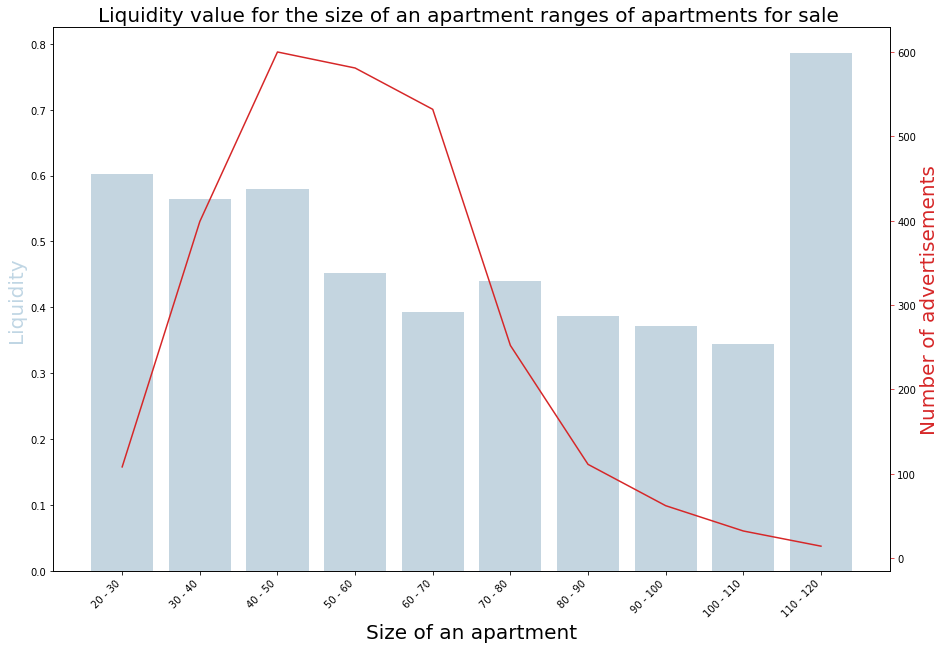

In [69]:
fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:green'
ax1.set_title('Liquidity value for the size of an apartment ranges of apartments for sale ', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.grid(False)
ax2 = sns.barplot(x='labels', y='reply', data = m_liq, color='#c0d6e4')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2 = sns.lineplot(x='labels', y='count', data = m_liq, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
ax2.grid(False)
ax1.set_ylabel('Liquidity', fontsize=20, color='#c0d6e4')
ax1.set_xlabel('Size of an apartment', fontsize=20)
ax2.set_ylabel('Number of advertisements', fontsize=20, color=color)
plt.savefig('m.png')
plt.show()

Najliczniej reprezentowane grupy mieszkań to te pomiędzy 30 a 80 m^2 powierzchni. W tych klasach wartość wskaźnika liquidity wynosi maksymalnie 58 % dla klasy 40-50 m^2 i minimalnie 39% dla klasy 60-70 m^2. 

#### Podsumowanie

Po rozdzieleniu zawartości kolumny params z tabeli ads możliwe było utworzenie nowych kolumn zawierających dodatkowe parametry. Wiele z nich posiada spore braki w danych, stąd nie jest możliwe przeanalizowanie ich wpływu na poziom liquidity. Część z tych parametrów nie wnosi żadnych istotnych informacji w kontekście liquidity np. "price[currency]". Jednak przeanalizowanie kilku parametrów (cena, metraż i liczba pokoi) uzyskanych z kolumny params pozwoliło na pokazanie zróżnicowania zainteresowania ofertami z kategorii: mieszkania na sprzedaż. Z pewnością dostęp do szerszego zbioru danych pozwoliłby na potwierdzenie postawionych z niniejszej analizie hipotez na temat wpływu czynników na poziom liquidity. 

Biorąc pod uwagę również inne - niezawarte w dostępnych danych czynniki, które mogą wpłynąć na zwiększenie zainteresowania ofertą myślę, że istotny może być sposób prezentacji nieruchomości, np.:
- czy oferta zawiera zdjęcia oraz czy są one wykonane estetycznie i prezentują nieruchomość w zachęcający sposób
- tytuł oferty
- opis oferty
- promowanie oferty w serwisie

Myślę, że na poziom liquidity może również wpływać: lokalizacja nieruchomości, stosunek jakości do ceny czy miesiąc, w którym publikowana jest oferta

In [70]:
conn.close()